# Imports

In [1]:
import requests, zipfile, io
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('adornmyplot.mplstyle')
import matplotlib as mpl

import pyvista as pv

import mmt_dipole_cuboid_inversion as dci
import mmt_dipole_cuboid_inversion.tools as dcit

import mmt_multipole_inversion as minv
import json

# Data

We start downloading the data of de Groot et al. (2018)\* from the public repository PANGAEA. The updated version of the data contains three areas that are pre-processed and where tomography and magnetometry coordinates are co-registered. We unzip the data and extract the contents.

*de Groot, L.V., Fabian, K., Béguin, A., Reith, P., Barnhoorn, A., Hilgenkamp, H., 2018. List of grains and results of the Scanning SQUID Magnetometer (SSM) scan. URL: https://doi.org/10.1594/PANGAEA.886724*

*de Groot, L.V., Fabian, K., Béguin, A., Reith, P., Barnhoorn, A., Hilgenkamp, H., 2018. Determining Individual Particle Magnetizations in Assemblages of Micrograins. Geophysical Research Letters 45, 2995–3000. URL: https://agupubs.onlinelibrary.wiley.com/doi/478*

In [2]:
# DATA ------------------------------------------------------------------------

# Download the data to this directory:
data_dir = Path('deGroot2018_data')
data_dir.mkdir(exist_ok=True)

if not any(data_dir.iterdir()):
    data_url = 'https://store.pangaea.de/Publications/deGroot-etal_2018/Micro-grain-data.zip'
    r = requests.get(data_url)
    # Pass the request output `r` (in byte-like format) to get a binary stream
    # from a data piece in memory (buffer) using BytesIO -> like a file in mem
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(data_dir)

    # Now open the ZIP file with formatted data:
    z = zipfile.ZipFile(data_dir / 'V2_2021-04.zip')
    z.extractall(data_dir)

The following are the magnetization values reported by (de Groot et al., 2018), for the grains in Area 2 with unknown magnetizations:

In [3]:
dG_Area2UMS = np.array([380.0, 7309.3, 18105.1, 3634.3, 9700.0, 7019.7])
dG_Area2UMS_m = np.array([(-379.2, 24.7, 2.0), (6715.8, -1335.3, 2557.4),
                          (-11556.0, -12780.3, -5560.4), (1925.9, -1814.4, -2491.4),
                          (2143.9, 9447.9, -480.4), (3438.4, -5851.8, -1791.7)])

# Compute the angles from dG's magnetizations
m = np.copy(dG_Area2UMS_m)
phi = np.arctan2(m[:, 1], m[:, 0])  # arctan(y / x)
theta = np.arccos(m[:, 2] / np.linalg.norm(m, axis=1))  # arccos(z / r) ; r = sqrt(x^2 + y^2 + z^2)

dG_Area2UMS_anglesNew = np.column_stack((np.rad2deg(phi), np.rad2deg(theta)))
dG_Area2UMS_anglesNew[:, 0][dG_Area2UMS_anglesNew[:, 0] < 0] += 360
ftr = np.logical_and(dG_Area2UMS_anglesNew[:, 1] >= 0, dG_Area2UMS_anglesNew[:, 1] <= 180)
dG_Area2UMS_anglesNew[:, 1][ftr] -= 90
dG_Area2UMS_anglesNew[:, 1][ftr] *= -1

In [4]:
print('Corrected angles from de Groot (2018) (z-axis towards depth):')
with np.printoptions(suppress=True):
    print(dG_Area2UMS_anglesNew)

Corrected angles from de Groot (2018) (z-axis towards depth):
[[176.27318214   0.3015511 ]
 [348.75456039  20.48027597]
 [227.8799832  -17.88560925]
 [316.70750689 -43.27667899]
 [ 77.21505331  -2.83878051]
 [300.43763848 -14.78771294]]


# Visualize grains

In this section we make a visualization of the tomographic data. Tomography voxels are already aggregated into the largest possible cuboids using the `cuboid_aggregation` algorithm included in the `mmt_dipole_cuboid_inversion` library. The visualization is done using the PyVista library.
* Notice that the `CuboidFile` in this case has an extra row that we must skip

In [5]:
data_dir = Path('deGroot2018_data/PDI-16803')
# Location and name of QDM and cuboid file
ScanFile = data_dir / 'Area2-90-fig2MMT.txt'
CuboidFile = data_dir / 'FWInput-FineCuboids-A2.txt'
cuboid_data = np.loadtxt(CuboidFile, skiprows=1)
cuboid_data[:, 2] *= -1
idxs = cuboid_data[:, 6].astype(np.int16)

In [6]:
print('Cuboid data example: x y z dx dy dz index')
print(cuboid_data[:2, :])

Cuboid data example: x y z dx dy dz index
[[265.76  59.    -4.84   2.64   1.76   1.32   1.  ]
 [262.24  57.24  -5.28   0.88   1.76   0.88   1.  ]]


In [7]:
# Make a block of data from every cuboid, for every particle; to plot the cuboids
block = pv.MultiBlock()
# g_idx = 1
for g_idx in range(1, len(np.unique(idxs)) + 1):  # for every particle
    for cuboid in cuboid_data[idxs == g_idx]:  # for each of its cuboids
        # remember dx dy dz are half-lengths so we multiply by 2 to get cuboid extents:
        c = pv.Cube(center=cuboid[:3], x_length=2*cuboid[3], y_length=2*cuboid[4], z_length=2*cuboid[5])
        c.cell_data['Gindex'] = [g_idx for i in range(6)]  # 
        block.append(c)

block = block.combine()

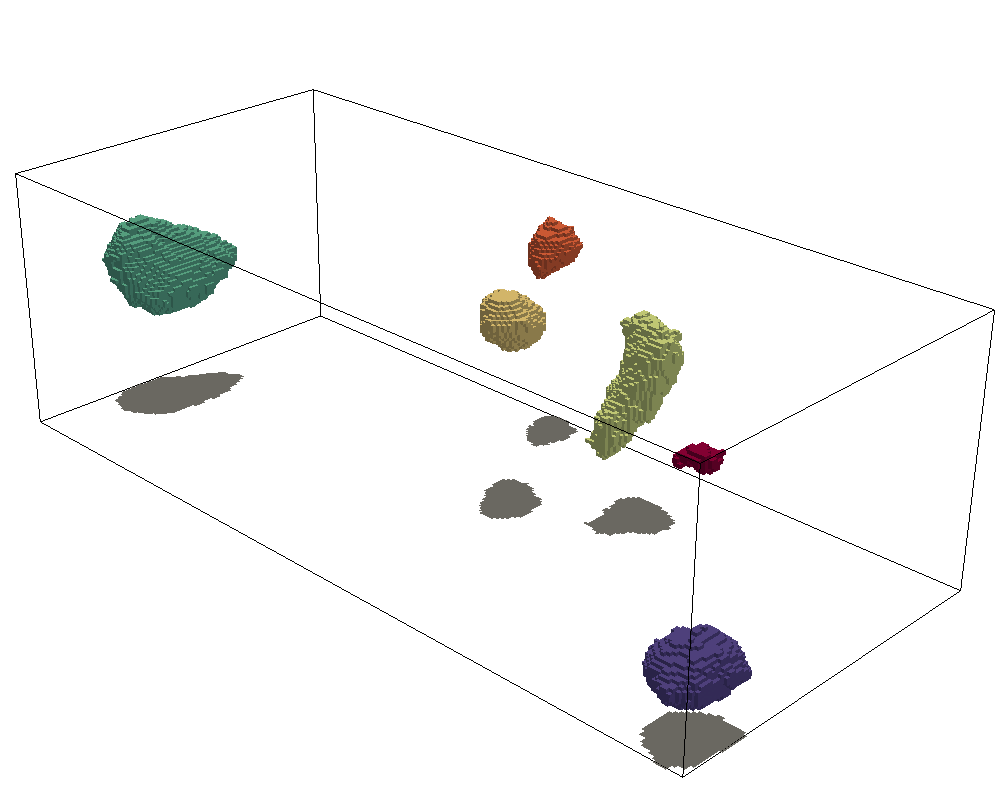

In [8]:
pV = pv.Plotter(off_screen=False, notebook=True, window_size=[1000, 800])
pV.set_background('white')

pV.add_mesh(block, scalars='Gindex', smooth_shading=False, show_scalar_bar=False,
            cmap='spectral')
# print (f"Loading mesh: {perf_counter() - t2}")

# Make the sample outline
box_lim = 0.17
box = pv.Box([cuboid_data[:, 0].min(), cuboid_data[:, 0].max(),
              cuboid_data[:, 1].min(), cuboid_data[:, 1].max(),
              cuboid_data[:, 2].min() - 10, 0.0])
pV.add_mesh(box.outline(), color='black', opacity=1, line_width=1)

# Make the grain shadows
pV.add_mesh(
    block.extract_geometry().project_points_to_plane(origin=(0, 0, cuboid_data[:, 2].min() - 10), 
                                                     normal=(0, 0, 1)),
                                                     opacity=1, style='surface', color='grey')
pV.view_isometric()
pV.camera.SetWindowCenter(0.07, -0.07)
pV.camera.zoom(1.35)
pV.camera.azimuth = -90
pV.camera.elevation = -10

pV.show(jupyter_backend='static')

# Dipole Cuboid Inversion

In this section we apply the homogeneously magnetized particle model to do the inversions. This means cuboids are asumed uniformly magnetized and we obtain dipole order solutions from the inversions.

In [9]:
data_dir = Path('deGroot2018_data/PDI-16803')

# location and name of QDM and cuboid file
ScanFile = data_dir / 'Area2-90-fig2MMT.txt'
CuboidFile = data_dir / 'FWInput-FineCuboids-A2.txt'

cub_data = np.loadtxt(CuboidFile, skiprows=1)
cub_data[:, 2] *= -1

SQUID_sensor_domain = np.array([[0, 0], [299, 199]]) * 1e-6
SQUID_spacing = 1e-6
SQUID_deltax = 0.5e-6
SQUID_deltay = 0.5e-6
SQUID_area = 1e-12
scan_height = 2e-6

mag_inv = dci.DipoleCuboidInversion(None, SQUID_sensor_domain, SQUID_spacing,
        SQUID_deltax, SQUID_deltay, SQUID_area, scan_height, verbose=True)

mag_inv.read_files(ScanFile, cub_data, cuboid_scaling_factor=1e-6)
mag_inv.set_scan_domain(gen_sd_mesh_from='sensor_center_domain')

# We then compute the forward (Green's) matrix that we use to invert the scan field:
mag_inv.prepare_matrix(method='cython')

# And we do the inversion:
mag_inv.calculate_inverse(method='scipy_pinv', rtol=1e-20)

Start inversion with 60000 knowns and 18 unknowns
Inversion has been carried out


In [10]:
mag_dpinv = np.linalg.norm(mag_inv.Mag.reshape(-1, 3), axis=1)

In [11]:
print('Dipole cuboid inversion code - Magnetic moments:')
print(mag_dpinv)

Dipole cuboid inversion code - Magnetic moments:
[  318.97933875  7199.13008917 17923.21224942  3581.60817045
  9674.98804707  6922.52904043]


In [12]:
print('Dipole cuboid inversion code - Magnetizations:')
mag_inv.Mag.reshape(-1, 3)

Dipole cuboid inversion code - Magnetizations:


array([[-3.18694976e+02,  1.05219197e+01,  8.40356448e+00],
       [ 6.59862292e+03, -1.35830832e+03, -2.53784319e+03],
       [-1.14150970e+04, -1.26655371e+04,  5.52460587e+03],
       [ 1.88781471e+03, -1.81085945e+03,  2.44639751e+03],
       [ 2.14199409e+03,  9.42277829e+03,  4.78021270e+02],
       [ 3.33188645e+03, -5.80285117e+03,  1.77393894e+03]])

In [13]:
# Compute spherical angles:
# array with the magnetizations. It's the same if we use normalized m
m = np.copy(mag_inv.Mag.reshape(-1, 3))
# mnorm = m / np.linalg.norm(m, axis=1)[:, np.newaxis]
phi = np.arctan2(m[:, 1], m[:, 0])  # arctan(y / x) for every row (particle)
theta = np.arccos(m[:, 2] / np.linalg.norm(m, axis=1))  # arccos(z / r) ; r = sqrt(x^2 + y^2 + z^2)

# Convert to degrees and correct angles: polar angles measured from equator and
# azimuthal angles in [0,360] degrees range
angles_dpinv = np.column_stack((np.rad2deg(phi), np.rad2deg(theta)))
angles_dpinv[:, 0][angles_dpinv[:, 0] < 0] += 360
ftr = np.logical_and(angles_dpinv[:, 1] >= 0, angles_dpinv[:, 1] <= 180)
angles_dpinv[:, 1][ftr] -= 90
angles_dpinv[:, 1][ftr] *= -1

In [14]:
print('Dipole cuboid inversion code - Angles:')
angles_dpinv

Dipole cuboid inversion code - Angles:


array([[178.10902985,   1.50964164],
       [348.36829599, -20.64157705],
       [227.97254004,  17.95304522],
       [316.1919339 ,  43.08200597],
       [ 77.19311148,   2.83201971],
       [299.86362052,  14.84801613]])

In [15]:
# Compute the volumes of the grains by summing its cuboid components
cuboidVols = np.zeros(8)
cuboidIdxs = cuboid_data[:, 6].astype(np.int16)
vols = 8 * cub_data[:, 3] * cub_data[:, 4] * cub_data[:, 5]
for i, particle_idx in enumerate(np.unique(cuboidIdxs)):
    p = cuboidIdxs == particle_idx
    cuboidVols[i] = vols[p].sum()

cuboidDepths = cub_data[:, 2] * (-1)

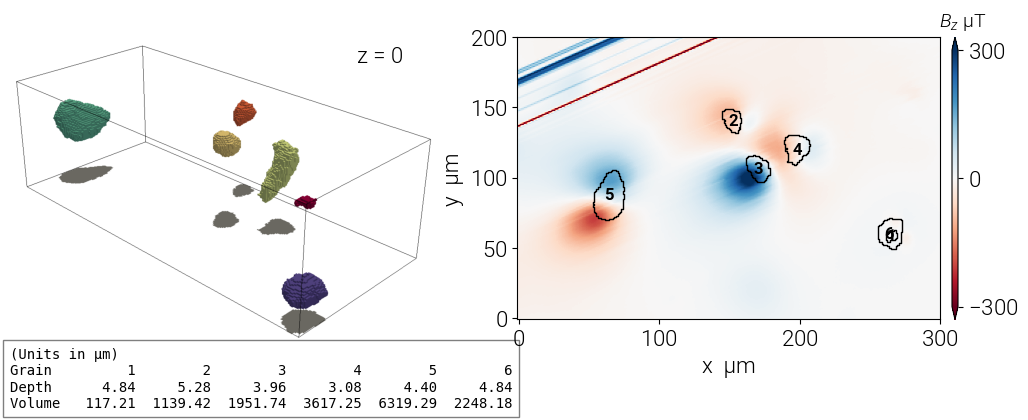

In [16]:
dcit.plot.set_grain_geometries(mag_inv, spatial_scaling=1e6)

f, axs = plt.subplots(ncols=2, figsize=(12, 8 * 200 / 350))

axs[0].imshow(pV.image)
axs[0].set_axis_off()
axs[0].text(0.93, 0.89, 'z = 0', va='top', ha='right',
            color='k', fontsize=16, transform=axs[0].transAxes)


# vlim = np.max(np.abs(mag_inv.scan_matrix / mag_inv.scan_area)) * 1e6
vlim = 300
dcit.plot.plot_grain_boundaries(mag_inv, axs[1], 
                                labels_args=dict(ha='center', va='center', fontsize=12, fontweight=600))
im = dcit.plot.plot_scan_field(mag_inv, axs[1], scale_field=1e6 / mag_inv.scan_area,
                               imshow_args=dict(cmap='RdBu', vmin=-vlim, vmax=vlim))
axs[1].set_xlabel('x  µm')
axs[1].set_ylabel('y  µm')

# COLORBAR
axL = axs[1].get_position()
axcb = f.add_axes([axL.x1 + 0.01, axL.y0, 0.005, axL.height])
cb = f.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-vlim, vmax=vlim), cmap='RdBu'), 
                cax=axcb, orientation='vertical', # shrink=0.7, aspect=10, # pad=-0.8
                extend='both')
cb.ax.xaxis.set_ticks_position('top')
cb.set_ticks((-vlim, 0, vlim))
cb.set_label(r'$B_{z}$' + ' µT', fontsize=14, y=1.15, rotation=0, labelpad=-40)

depthLab = '(Units in µm)\n'
depthLab += 'Grain '
for i in range(len(np.unique(cuboidIdxs))):
    depthLab += f'{i + 1:>9}'
depthLab += '\nDepth '
for i in range(len(np.unique(cuboidIdxs))):
    depthLab += f'{cuboidDepths[i]:>9.2f}'

depthLab += '\nVolume'
for i in range(len(np.unique(cuboidIdxs))):
    depthLab += f'{cuboidVols[i]:>9.2f}'

axs[0].text(0., 0.0, depthLab, va='top', ha='left',
            color='k', fontsize=10, fontfamily='monospace',
            bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5},
            transform=axs[0].transAxes)


plt.savefig('figures/area2_degroot18_overview.pdf', bbox_inches='tight', dpi=200)
plt.show()

In [17]:
print(depthLab)

(Units in µm)
Grain         1        2        3        4        5        6
Depth      4.84     5.28     3.96     3.08     4.40     4.84
Volume   117.21  1139.42  1951.74  3617.25  6319.29  2248.18


# Multipole Inversion

In this section we apply the multipole expansion model for the inversions, thus we use the `mmt_multipole_inversion library`. Start by computing the particle centers from the tomography/cuboids data:

In [18]:
# -----------------------------------------------------------------------------
# DEFINE PARTICLES

data_dir = Path('deGroot2018_data/PDI-16803')

# Location and name of QDM and cuboid file
ScanFile = data_dir / 'Area2-90-fig2MMT.txt'
CuboidFile = data_dir / 'FWInput-FineCuboids-A2.txt'
# Load center and half lengths of cuboids making the grains (tomog data)
cuboid_data = np.loadtxt(CuboidFile, skiprows=1)
# x, y = np.copy(cuboid_data[:, 0]), np.copy(cuboid_data[:, 1])
# cuboid_data[:, 0] = y
# cuboid_data[:, 1] = x
cuboid_data[:, 2] *= -1

cuboid_data_idxs = cuboid_data[:, 6].astype(np.int16)
cx, cy, cz, cdx, cdy, cdz = (cuboid_data[:, i] for i in range(6))
vols = 8 * cdx * cdy * cdz

# Compute centers of mass (geometric centre) per p. into the particles array
particles = np.zeros((len(np.unique(cuboid_data_idxs)), 4))
centre = np.zeros(3)
for i, particle_idx in enumerate(np.unique(cuboid_data_idxs)):

    p = cuboid_data_idxs == particle_idx
    particle_vol = vols[p].sum()
    centre[0] = np.sum(cx[p] * vols[p]) / particle_vol
    centre[1] = np.sum(cy[p] * vols[p]) / particle_vol
    centre[2] = np.sum(cz[p] * vols[p]) / particle_vol

    particles[i][:3] = centre
    particles[i][3] = particle_vol

Now we define the sample:

In [19]:
# Get the dimensions of the magnetometry scan:
scan_area = np.shape(np.loadtxt(data_dir / 'Area2-90-fig2MMT.txt'))
# N particles:
Nparticles = len(np.unique(cuboid_data_idxs))

In [20]:
# -----------------------------------------------------------------------------
# DEFINE SAMPLE

# Directory to save the files
BASE_DIR = Path('SyntheticSampleFiles')
BASE_DIR.mkdir(exist_ok=True)

# Scale the positions and columes by micrometres
np.savez(BASE_DIR / 'Area2_UMS_NPZ_ARRAYS',
         # Bz_array=,
         particle_positions=particles[:, :3] * 1e-6,
         # magnetization=self.magnetization,
         volumes=particles[:, 3] * 1e-18)

# Set dictionary with scanning surface parameters
metadict = {}
metadict["Scan height Hz"] = 2e-6
metadict["Scan area x-dimension Sx"] = scan_area[1] * 1e-6
metadict["Scan area y-dimension Sy"] = scan_area[0] * 1e-6
metadict["Scan x-step Sdx"] = 1e-6
metadict["Scan y-step Sdy"] = 1e-6
metadict["Time stamp"] = '0000'
metadict["Number of particles"] = Nparticles
# Important!:
metadict["Sensor dimensions"] = (0.5e-6, 0.5e-6)

# Save dictionary into json file
with open(BASE_DIR / "AREA2_UMS_METADICT.json", 'w') as f:
    json.dump(metadict, f)

And, finally, we make the inversions using a 2D model for the magnetometer sensors. This is useful to compare the solutions against the HMP model:

In [21]:
# -----------------------------------------------------------------------------
# INVERSION

inv_area2_ums = minv.MultipoleInversion(
        BASE_DIR / "AREA2_UMS_METADICT.json",
        BASE_DIR / 'Area2_UMS_NPZ_ARRAYS.npz',
        expansion_limit='dipole',
        sus_functions_module='spherical_harmonics_basis_area')
# inv_area2_ums.sensor_dims = ()
# Load the scanning array manually:
inv_area2_ums.Bz_array = np.loadtxt(data_dir / 'Area2-90-fig2MMT.txt')

mag_minv_raw = {}
mag_minv = {}
angles_minv = {}
angles_minv_raw = {}
berr_minv = {}

for exp_limit in ['dipole', 'quadrupole']:
# for exp_limit in ['dipole']:
    inv_area2_ums.expansion_limit = exp_limit
    inv_area2_ums.compute_inversion(method='sp_pinv', rtol=1e-20)
    # inv_area2_ums.compute_inversion(rcond=1e-30, method='np_pinv')
    
    # print(inv_area2_ums.inv_multipole_moments[:, :3] / inv_area2_ums.volumes[:, None])
    
    # Compute magnetizations:
    mag = inv_area2_ums.inv_multipole_moments[:, :3] / inv_area2_ums.volumes[:, None]
    mag_area2_ums = np.sqrt(np.sum(mag ** 2, axis=1))
    
    mag_minv_raw[exp_limit] = inv_area2_ums.inv_multipole_moments[:, :3]
    
    # Compute spherical angles:
    m = mag / np.linalg.norm(m, axis=1)[:, None]  # normalized mag

    # phi = arctan(y / x)
    phi_area2_ums = np.arctan2(m[:, 1], m[:, 0])
    # theta = arccos(z / r) ; r = sqrt(x^2 + y^2 + z^2)
    theta_area2_ums = np.arccos(m[:, 2] / np.linalg.norm(m, axis=1))
 
    mag_minv[exp_limit] = mag_area2_ums
    angles_minv[exp_limit] = np.column_stack((np.rad2deg(phi_area2_ums),
                                              np.rad2deg(theta_area2_ums)))
   
    angles_minv[exp_limit][:, 0][angles_minv[exp_limit][:, 0] < 0] += 360
    ftr = np.logical_and(angles_minv[exp_limit][:, 1] >= 0, angles_minv[exp_limit][:, 1] <= 180)
    angles_minv[exp_limit][:, 1][ftr] -= 90
    angles_minv[exp_limit][:, 1][ftr] *= -1
    
    angles_minv_raw[exp_limit] = np.column_stack((np.rad2deg(phi_area2_ums),
                                                  np.rad2deg(theta_area2_ums)))
    
    berr_minv[exp_limit] = np.linalg.norm(inv_area2_ums.inv_Bz_array - inv_area2_ums.Bz_array)
    berr_minv[exp_limit] /= np.linalg.norm(inv_area2_ums.Bz_array)

*Bz_array* array required for calculations.  Set manually.
Parameter Sensor origin x not found in json file
Setting Sensor origin x value to 0.0
Parameter Sensor origin y not found in json file
Setting Sensor origin y value to 0.0
Scanning array size = 300 x 200
Generating forward matrix
Generation of Q matrix took: 6.9686 s
Using scipy.linalg.pinv for inversion
Generating forward matrix
Generation of Q matrix took: 2.0779 s
Using scipy.linalg.pinv for inversion


In [22]:
print('Multipole inversion code - Magnetizations:')
print(mag_minv)

Multipole inversion code - Magnetizations:
{'dipole': array([  242.7127847 ,  6955.07486148, 17957.89706254,  3633.53215337,
        9113.19519644,  6765.2641722 ]), 'quadrupole': array([ 1665.208323  , 15610.159614  , 23318.22064007,  6595.84290504,
        6064.27683923, 16428.05299163])}


In [23]:
print('Multipole inversion code - Magnetizations:')
print(angles_minv['dipole'])

Multipole inversion code - Magnetizations:
[[177.62372418   3.48524702]
 [346.91263978 -20.12767915]
 [228.70939906  16.77905391]
 [319.46842281  50.80219256]
 [ 77.92917874   4.81795857]
 [299.29641932  16.1827879 ]]


In [24]:
print('Multipole inversion code - Angles:')
angles_minv

Multipole inversion code - Angles:


{'dipole': array([[177.62372418,   3.48524702],
        [346.91263978, -20.12767915],
        [228.70939906,  16.77905391],
        [319.46842281,  50.80219256],
        [ 77.92917874,   4.81795857],
        [299.29641932,  16.1827879 ]]),
 'quadrupole': array([[236.35935933, -15.79019901],
        [348.86903852,  -2.54402337],
        [212.70680407,  12.82255783],
        [302.60443798,  -1.29631521],
        [ 82.02488308,  -2.40327815],
        [270.61785888,  -8.47266816]])}

## Multipole Inversion: Point Source

Here we perform multipole inversions but modelling the sensors as point sources (for comparison)

In [25]:
# -----------------------------------------------------------------------------
# INVERSION

inv_area2_ums = minv.MultipoleInversion(
        BASE_DIR / "AREA2_UMS_METADICT.json",
        BASE_DIR / 'Area2_UMS_NPZ_ARRAYS.npz',
        expansion_limit='dipole',
        sus_functions_module='spherical_harmonics_basis')
inv_area2_ums.sensor_dims = ()
# Load the scanning array manually:
inv_area2_ums.Bz_array = np.loadtxt(data_dir / 'Area2-90-fig2MMT.txt')

mag_minv_ps = {}
angles_minv_ps = {}
angles_minv_ps_raw = {}

for exp_limit in ['dipole', 'quadrupole', 'octupole']:
# for exp_limit in ['dipole']:
    inv_area2_ums.expansion_limit = exp_limit
    inv_area2_ums.compute_inversion(method='sp_pinv', rtol=1e-20)
    # inv_area2_ums.compute_inversion(rcond=1e-30, method='np_pinv')
    
    # print(inv_area2_ums.inv_multipole_moments[:, :3] / inv_area2_ums.volumes[:, None])
    
    # Compute magnetizations:
    mag = inv_area2_ums.inv_multipole_moments[:, :3] / inv_area2_ums.volumes[:, None]
    mag_area2_ums = np.sqrt(np.sum(mag ** 2, axis=1))
    
    # Compute sph angles:
    m = mag / np.linalg.norm(m, axis=1)[:, None]

    # phi = arctan(y / x)
    phi_area2_ums = np.arctan2(m[:, 1], m[:, 0])
    # theta = arccos(z / r) ; r = sqrt(x^2 + y^2 + z^2)
    theta_area2_ums = np.arccos(m[:, 2] / np.linalg.norm(m, axis=1))

    mag_minv_ps[exp_limit] = mag_area2_ums
    angles_minv_ps[exp_limit] = np.column_stack((np.rad2deg(phi_area2_ums),
                                                 np.rad2deg(theta_area2_ums)))
   
    angles_minv_ps[exp_limit][:, 0][angles_minv_ps[exp_limit][:, 0] < 0] += 360
    ftr = np.logical_and(angles_minv_ps[exp_limit][:, 1] >= 0, angles_minv_ps[exp_limit][:, 1] <= 180)
    angles_minv_ps[exp_limit][:, 1][ftr] -= 90
    angles_minv_ps[exp_limit][:, 1][ftr] *= -1
    
    angles_minv_ps_raw[exp_limit] = np.column_stack((np.rad2deg(phi_area2_ums),
                                                     np.rad2deg(theta_area2_ums)))

*Bz_array* array required for calculations.  Set manually.
Parameter Sensor origin x not found in json file
Setting Sensor origin x value to 0.0
Parameter Sensor origin y not found in json file
Setting Sensor origin y value to 0.0
Scanning array size = 300 x 200
Generating forward matrix
Generation of Q matrix took: 3.5454 s
Using scipy.linalg.pinv for inversion
Generating forward matrix
Generation of Q matrix took: 3.8981 s
Using scipy.linalg.pinv for inversion
Generating forward matrix
Generation of Q matrix took: 8.2704 s
Using scipy.linalg.pinv for inversion


In [26]:
print('Multipole inversion code - Magnetizations:')
print(mag_minv_ps)

Multipole inversion code - Magnetizations:
{'dipole': array([  239.75798394,  6949.52805036, 17948.48271282,  3630.84107582,
        9111.73923417,  6760.28278858]), 'quadrupole': array([ 1646.45594545, 15596.56655922, 23319.56804448,  6588.18822547,
        6066.59944533, 16428.78798886]), 'octupole': array([ 1633.41511274, 28901.0044739 , 27999.53069012, 20524.98320693,
        9044.07324205, 77181.33899075])}


# Comparison

In this section we compute the relative errors $B_{\text{err}}$ and the comparison of the magnetization values between the HMP model, the MPE model, and the original data reported by de Groot et al. (2018)

In [27]:
# Not a good indicator as there are grains with very large errors
Berrs = np.zeros(3)

dci_bzinv = mag_inv.forward_field()
dci_bz = mag_inv.scan_matrix / mag_inv.scan_area
Berrs[0] = np.linalg.norm(dci_bzinv - dci_bz, ord='fro')
Berrs[0] /= np.linalg.norm(dci_bz, ord='fro')

Berrs[1] = berr_minv['dipole']
Berrs[2] = berr_minv['quadrupole']

In [28]:
Nparticles = len(np.unique(cuboid_data_idxs))

In [29]:
# header = f"{'MultInv[dipole]':>27}"
# header += f"{'MultInv[quadrup]':>22}"
# # header += f"{'MultInv[octupole]':>22}"
# header += f"{'DipCubInv':>15}"
# header += f"{'de Groot (2018)':>22}"
# print('Inversion error Berr')
# print('-' * 87)
# print(header)
# print('-' * 87)
# print(f'{Berrs[0]:>22.2f}')

print('Magnetization in units of A / m')
print('-' * 87)
header = f"{'Grain':>5}"
header += f"{'MultInv[dipole]':>22}"
header += f"{'MultInv[quadrup]':>22}"
# header += f"{'MultInv[octupole]':>22}"
header += f"{'DipCubInv':>15}"
header += f"{'de Groot (2018)*':>22}"
print(header)
print('-' * 87)
for i in range(Nparticles):
    res = f"{i + 1:>3}"
    res += f"{mag_minv['dipole'][i]:>22.3f}"
    res += f"{mag_minv['quadrupole'][i]:>20.3f}"
    # res += f"{mag_minv['octupole'][i]:>22.3f}"
    res += f"{mag_dpinv[i]:>19.3f}"
    res += f"{dG_Area2UMS[i]:>20.3f}"
    
    print(res)

print('\nPairs of (φ,θ) magnetization angles in degrees. Polar angles positive above the equator')
print('-' * 87)
print(header)
print('-' * 87)
for i in range(Nparticles):
    res = f"{i + 1:>3}"
    res += f"{'(':>9}{angles_minv['dipole'][i][0]:>6.2f}, {angles_minv['dipole'][i][1]:>6.2f})"
    res += f"{'(':>6}{angles_minv['quadrupole'][i][0]:>6.2f}, {angles_minv['quadrupole'][i][1]:>6.2f})"
    # res += f"{mag_minv['octupole'][i]:>19.3f}"
    res += f"{'(':>4}{angles_dpinv[i][0]:>6.2f}, {angles_dpinv[i][1]:>6.2f})"
    res += f"{'(':>3}{dG_Area2UMS_anglesNew[i][0]:>6.2f}, {-dG_Area2UMS_anglesNew[i][1]:>6.2f})"
    
    print(res)

print('\n * Positive z-axis in de Groot (2018) point towards depth.')
print('   θ values here are inverted. φ values are re-computed.')
print('\n- Multipole Inversions using area sensors\n')

Magnetization in units of A / m
---------------------------------------------------------------------------------------
Grain       MultInv[dipole]      MultInv[quadrup]      DipCubInv      de Groot (2018)*
---------------------------------------------------------------------------------------
  1               242.713            1665.208            318.979             380.000
  2              6955.075           15610.160           7199.130            7309.300
  3             17957.897           23318.221          17923.212           18105.100
  4              3633.532            6595.843           3581.608            3634.300
  5              9113.195            6064.277           9674.988            9700.000
  6              6765.264           16428.053           6922.529            7019.700

Pairs of (φ,θ) magnetization angles in degrees. Polar angles positive above the equator
---------------------------------------------------------------------------------------
Grain       MultIn

The following is the same comparison but using point-sensors for the Multipole inversions:

In [30]:
print('\n' + '-' * 100)
header = f"{'Grain':>5}"
header += f"{'MultInv[dipole]':>20}"
header += f"{'MultInv[quadrupole]':>20}"
header += f"{'MultInv[octupole]':>20}"
header += f"{'DipoleInv':>14}"
header += f"{'de Groot (2018)':>20}"
print(header)

for i in range(Nparticles):
    res = f"{i + 1:>3}"
    res += f"{mag_minv_ps['dipole'][i]:>19.3f}"
    res += f"{mag_minv_ps['quadrupole'][i]:>19.3f}"
    res += f"{mag_minv_ps['octupole'][i]:>19.3f}"
    res += f"{mag_dpinv[i]:>19.3f}"
    res += f"{dG_Area2UMS[i]:>19.3f}"
    
    print(res)
    
print('\n- Multipole Inversion using point sensors')


----------------------------------------------------------------------------------------------------
Grain     MultInv[dipole] MultInv[quadrupole]   MultInv[octupole]     DipoleInv     de Groot (2018)
  1            239.758           1646.456           1633.415            318.979            380.000
  2           6949.528          15596.567          28901.004           7199.130           7309.300
  3          17948.483          23319.568          27999.531          17923.212          18105.100
  4           3630.841           6588.188          20524.983           3581.608           3634.300
  5           9111.739           6066.599           9044.073           9674.988           9700.000
  6           6760.283          16428.788          77181.339           6922.529           7019.700

- Multipole Inversion using point sensors
